
# Q-GAN

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned. Then run this command 'pip install -e gym/[all]'.

In [3]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    if done:
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
print('rewards min and max:', np.max(np.array(rewards)), np.min(np.array(rewards)))
print('state size:', np.array(states).shape, 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
actions: 1 0
rewards min and max: 1.0 1.0
state size: (10, 4) action size: 2


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [6]:
# Data of the model
def model_input(state_size):
    # Current and next states given
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    
    # Previous and current actions given
    prev_actions = tf.placeholder(tf.int32, [None], name='prev_actions')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    
    # End of episodes/goal/task where nextQs = 0 and Qs=rs
    dones = tf.placeholder(tf.bool, [None], name='dones') # masked

    # Qs = qs+ (gamma * nextQs)
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs') # masked
    
    # returning the given data to the model
    return prev_actions, states, actions, next_states, dones, targetQs

In [7]:
# Generator: Generating/predicting action and next states
def generator(prev_actions, states, action_size, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # Fusing states and actions
        x_fused = tf.concat(axis=1, values=[prev_actions, states])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=(action_size + state_size))
        actions_logits, next_states_logits = tf.split(axis=1, num_or_size_splits=[action_size, state_size], 
                                                      value=logits)
        #predictions = tf.nn.softmax(actions_logits)
        #predictions = tf.sigmoid(next_states_logits)

        # return actions and states logits
        return actions_logits, next_states_logits

In [8]:
def discriminator(prev_actions, states, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusing states and actions
        x_fused = tf.concat(axis=1, values=[prev_actions, states])
        #print(x_fused.shape)
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        #print(h1.shape)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        #print(h2.shape)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)
        #predictions = tf.nn.softmax(logits)

        # return reward logits/Qs
        return logits

In [9]:
# Qs for D to be used as the target/label
def model_output(prev_actions, states, 
                 action_size, hidden_size):
    # Discriminator for Qs/targetQs
    prev_actions_onehot = tf.one_hot(indices=prev_actions, depth=action_size)
    Qs = discriminator(prev_actions=prev_actions_onehot, states=states, hidden_size=hidden_size)
    
    # Qs will be used as a targetQs/labels
    return Qs

In [10]:
# Calculating the loss of generator based on the generated/predicted states and actions
def model_loss(prev_actions, states, actions, next_states, dones, targetQs, 
               state_size, action_size, hidden_size):
    # Generator for nextQs_fake_unmasked
    prev_actions_onehot = tf.one_hot(indices=prev_actions, depth=action_size)
    actions_logits, next_states_logits = generator(prev_actions=prev_actions_onehot, states=states,
                                                   hidden_size=hidden_size, state_size=state_size, 
                                                   action_size=action_size)
    
    # Discriminator for nextQs_fake_unmasked
    actions_predictions = tf.nn.softmax(actions_logits)
    nextQs_fake_unmasked = discriminator(prev_actions=actions_predictions, states=next_states_logits,
                                         hidden_size=hidden_size, reuse=True)
    
    # Discriminator for nextQs_real_unmasked
    actions_onehot = tf.one_hot(indices=actions, depth=action_size)
    nextQs_real_unmasked = discriminator(prev_actions=actions_onehot, states=next_states,
                                         hidden_size=hidden_size, reuse=True)
    
    # Masking the unmasked nextQs using dones
    dones_mask = tf.reshape(tensor=(1 - tf.cast(dtype=nextQs_fake_unmasked.dtype, x=dones)), shape=[-1, 1])
    nextQs_fake_masked = tf.multiply(nextQs_fake_unmasked, dones_mask)
    nextQs_real_masked = tf.multiply(nextQs_real_unmasked, dones_mask)
    nextQs_fake = tf.reduce_max(axis=1, input_tensor=nextQs_fake_masked)
    nextQs_real = tf.reduce_max(axis=1, input_tensor=nextQs_real_masked)
    targetQs = tf.reshape(targetQs, [-1])
    #print(nextQs_fake.shape, nextQs_real.shape, targetQs.shape)

    # Adverserial learning/training
    # d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_real, 
    #                                                                  labels=tf.sigmoid(targetQs)))
    # d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_fake, 
    #                                                                  labels=tf.zeros_like(targetQs)))
    d_loss_real = tf.reduce_mean(tf.square(nextQs_real - targetQs))
    #d_loss_fake = tf.reduce_mean(tf.square(nextQs_fake - tf.zeros_like(targetQs)))
    d_loss_fake = tf.reduce_mean(tf.square(nextQs_fake))
    d_loss = d_loss_real + d_loss_fake
    
    # Adverserial learning/training
    # g_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_real, 
    #                                                                      labels=tf.zeros_like(targetQs)))
    # g_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_fake,
    #                                                                      labels=tf.sigmoid(targetQs)))
    #g_loss_real = tf.reduce_mean(tf.square(nextQs_real - tf.zeros_like(targetQs)))
    g_loss_real = tf.reduce_mean(tf.square(nextQs_real))
    g_loss_fake = tf.reduce_mean(tf.square(nextQs_fake - targetQs))
    g_loss = g_loss_real + g_loss_fake
    
    # Returning the D loss
    return actions_logits, g_loss, d_loss

In [11]:
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss for next state and action prediction
    :param d_loss: Discriminator loss for reward prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Used for BN (batchnorm params)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars) # action prediction
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars) # reward prediction

    return g_opt, d_opt

In [12]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        ####################################### Model data inputs/outputs #######################################
        # Input of the Model: make the data available inside the framework
        self.prev_actions, self.states, self.actions, self.next_states, self.dones, self.targetQs = model_input(
            state_size=state_size)
        
        ######################################## Model losses #####################################################
        # Loss of the Model: action prediction/generation
        self.Qs = model_output(prev_actions=self.prev_actions, states=self.states,
                               action_size=action_size, hidden_size=hidden_size)
        
        # NOTE: Qs will be outputed and targetQs are the Qs used as labels
        self.actions_logits, self.g_loss, self.d_loss = model_loss(targetQs=self.targetQs, dones=self.dones, 
                                                                   prev_actions=self.prev_actions, 
                                                                   states=self.states, actions=self.actions,
                                                                   next_states=self.next_states,
                                                                   state_size=state_size, action_size=action_size, 
                                                                   hidden_size=hidden_size)

        ######################################## Model updates #####################################################
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, 
                                           d_loss=self.d_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [13]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [14]:
print('state size:', np.array(states).shape[1], 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

state size: 4 action size: 2


In [15]:
# Training params
train_episodes = 10000          # max number of episodes to learn from
max_steps = 2000000000000000   # max steps in an episode

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000           # memory capacity
batch_size = 200               # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [16]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

## Populate the memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [17]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
prev_action = env.action_space.sample() # At-1
state, _, done, _ = env.step(prev_action) # St, Rt/Et (Epiosde)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Make a random action
    action = env.action_space.sample()# At
    next_state, _, done, _ = env.step(action) #St+1

    # End of the episodes which defines the goal of the episode/mission
    if done is True:
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        prev_action = env.action_space.sample()
        state, _, done, _ = env.step(prev_action)
    else:
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Prepare for the next round
        prev_action = action
        state = next_state

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [18]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = []
g_loss_list = []
d_loss_list = []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        g_loss = 0
        d_loss = 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.prev_actions: np.array([prev_action]), 
                             model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits) # arg with max value/Q is the class of action
            
            # Take action, get new state and reward
            next_state, _, done, _ = env.step(action)
    
            # Cumulative reward
            #total_reward += reward
            total_reward += 1 # done=False
            
            # Episode/epoch training is done/failed!
            if done is True:
                # the episode ends so no next state
                #next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                g_loss_list.append((ep, g_loss))
                d_loss_list.append((ep, d_loss))
                
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, _, done, _ = env.step(prev_action)

            else:
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # One step forward: At-1=At and St=St+1
                prev_action = action
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            prev_actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            actions = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            
            # Calculating nextQs and setting them to 0 for states where episode ends/fails
            feed_dict={model.prev_actions: prev_actions, model.states: states}
            Qs = sess.run(model.Qs, feed_dict)
            #print(len(Qs), Qs.shape, np.reshape(Qs, [-1]).shape)
            targetQs = np.reshape(Qs, [-1])
            
            # Calculating nextQs for Discriminator using D(At-1, St)= Qt: NOT this one
            # NextQs/Qt+1 are given both:
            feed_dict = {model.prev_actions: prev_actions, 
                         model.states: states, 
                         model.actions: actions, 
                         model.next_states: next_states, 
                         model.dones: dones,
                         model.targetQs: targetQs}
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
                        
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 1 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.9999
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 18 Training g_loss: 0.0051 Training d_loss: 0.0016 Explore P: 0.9981
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 16 Training g_loss: 0.0005 Training d_loss: 0.0004 Explore P: 0.9965
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 30 Training g_loss: 0.0001 Training d_loss: 0.0001 Explore P: 0.9936
-----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 33 Total reward: 33 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.9295
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 34 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.9287
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 35 Total reward: 13 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.9275
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 36 Total reward: 20 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.9257
-------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 66 Total reward: 26 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.8595
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 67 Total reward: 14 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.8583
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 68 Total reward: 15 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.8570
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 69 Total reward: 20 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.8553
------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 100 Total reward: 22 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.8136
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 101 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.8127
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 102 Total reward: 26 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.8106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 103 Total reward: 14 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.8095
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 133 Total reward: 25 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.7733
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 134 Total reward: 18 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.7720
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 135 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.7712
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 136 Total reward: 16 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.7700
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 166 Total reward: 21 Training g_loss: 0.0001 Training d_loss: 0.0000 Explore P: 0.7220
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 167 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.7212
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 168 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.7205
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 169 Total reward: 27 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.7186
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 200 Total reward: 16 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.6771
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 201 Total reward: 13 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.6762
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 202 Total reward: 15 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.6752
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 203 Total reward: 41 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.6725
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 233 Total reward: 23 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.6384
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 234 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.6377
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 235 Total reward: 27 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.6360
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 236 Total reward: 26 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.6344
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 266 Total reward: 13 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.6113
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 267 Total reward: 13 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.6105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 268 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.6100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 269 Total reward: 32 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.6081
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 300 Total reward: 14 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.5783
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 301 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.5776
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 302 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.5770
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 303 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.5763
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 333 Total reward: 20 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.5492
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 334 Total reward: 18 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.5482
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 335 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.5478
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 336 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.5472
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 366 Total reward: 17 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.5244
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 367 Total reward: 13 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.5237
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 368 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.5232
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 369 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.5227
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 399 Total reward: 14 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.5002
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 400 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.4997
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 401 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.4992
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 402 Total reward: 17 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.4983
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 433 Total reward: 18 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.4781
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 434 Total reward: 13 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.4775
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 435 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.4770
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 436 Total reward: 17 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.4762
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 467 Total reward: 13 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.4576
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 468 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.4572
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 469 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.4568
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 470 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.4564
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 501 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.4378
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 502 Total reward: 15 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.4371
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 503 Total reward: 15 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.4365
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 504 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.4361
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 534 Total reward: 13 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.4197
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 535 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.4192
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 536 Total reward: 16 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.4186
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 537 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.4182
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 567 Total reward: 17 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.4028
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 568 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.4024
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 569 Total reward: 16 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.4017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 570 Total reward: 14 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.4012
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 600 Total reward: 19 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.3870
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 601 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.3867
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 602 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.3863
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 603 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.3860
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 634 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.3719
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 635 Total reward: 14 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.3714
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 636 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.3710
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 637 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.3706
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 667 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.3567
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 668 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.3563
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 669 Total reward: 16 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.3558
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 670 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.3554
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 701 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.3431
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 702 Total reward: 13 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.3427
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 703 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.3424
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 704 Total reward: 14 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.3419
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 735 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.3299
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 736 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.3295
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 737 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.3292
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 738 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.3289
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 769 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.3185
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 770 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.3181
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 771 Total reward: 15 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.3177
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 772 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.3174
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 804 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.3071
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 805 Total reward: 16 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.3067
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 806 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.3064
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 807 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.3061
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 839 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2951
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 840 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2949
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 841 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2946
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 842 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2944
-----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 872 Total reward: 15 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2851
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 873 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2847
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 874 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2845
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 875 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2842
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 905 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2754
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 906 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2752
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 907 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2750
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 908 Total reward: 18 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2745
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 938 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2664
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 939 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2662
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 940 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2659
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 941 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2656
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 972 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2570
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 973 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2568
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 974 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2565
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 975 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2563
-----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1006 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2481
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1007 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2479
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1008 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2477
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1009 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2474
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1038 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2400
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1039 Total reward: 17 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2396
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1040 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2394
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1041 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2392
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1070 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2318
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1071 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2317
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1072 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2314
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1073 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2312
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1102 Total reward: 14 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2242
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1103 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2240
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1104 Total reward: 14 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2237
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1105 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2235
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1134 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2173
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1135 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2171
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1136 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2169
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1137 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2167
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1166 Total reward: 14 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1167 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1168 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2098
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1169 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2096
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1198 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2034
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1199 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2033
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1200 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1201 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.2028
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1230 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1968
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1231 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1966
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1232 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1965
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1233 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1963
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1262 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1908
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1263 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1906
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1264 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1904
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1265 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1902
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1295 Total reward: 16 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1849
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1296 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1847
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1297 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1846
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1298 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1844
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1328 Total reward: 17 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1788
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1329 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1786
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1330 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1785
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1331 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1783
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1360 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1734
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1361 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1732
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1362 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1730
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1363 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1728
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1392 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1677
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1393 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1676
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1394 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1674
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1395 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1673
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1424 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1627
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1425 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1625
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1426 Total reward: 13 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1623
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1427 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1622
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1456 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1576
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1457 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1575
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1458 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1573
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1459 Total reward: 13 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1571
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1488 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1527
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1489 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1526
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1490 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1525
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1491 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1523
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1520 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1480
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1521 Total reward: 13 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1478
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1522 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1477
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1523 Total reward: 14 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1475
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1553 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1433
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1554 Total reward: 13 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1431
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1555 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1429
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1556 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1428
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1586 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1388
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1587 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1387
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1588 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1386
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1589 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1385
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1619 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1346
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1620 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1345
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1621 Total reward: 15 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1343
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1622 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1342
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1652 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1306
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1653 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1305
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1654 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1304
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1655 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1303
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1684 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1269
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1685 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1268
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1686 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1267
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1687 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1266
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1717 Total reward: 13 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1231
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1718 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1230
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1719 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1229
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1720 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1228
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1749 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1197
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1750 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1196
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1751 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1194
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1752 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1193
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1782 Total reward: 14 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1159
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1783 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1158
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1784 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1157
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1785 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1156
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1814 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1126
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1815 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1125
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1816 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1124
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1817 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1123
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1846 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1093
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1847 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1092
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1848 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1091
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1849 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1090
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1879 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1061
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1880 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1061
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1881 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1060
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1882 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1059
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1912 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1031
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1913 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1914 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1915 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1029
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1945 Total reward: 13 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1003
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1946 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1002
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1947 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1001
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1948 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.1000
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1978 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0973
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1979 Total reward: 14 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0972
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1980 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0971
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1981 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0970
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2010 Total reward: 13 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0945
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2011 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0945
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2012 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0944
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2013 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0943
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2043 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0919
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2044 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0918
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2045 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0917
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2046 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0916
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2076 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0893
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2077 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0892
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2078 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0892
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2079 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0891
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2108 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0869
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2109 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0868
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2110 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0867
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2111 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0867
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2140 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0845
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2141 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0844
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2142 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0843
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2143 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0842
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2173 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0821
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2174 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0820
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2175 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0820
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2176 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0819
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2206 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0797
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2207 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0797
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2208 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0796
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2209 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0796
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2238 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0776
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2239 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0775
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2240 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0775
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2241 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0774
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2270 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0756
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2271 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0755
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2272 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0754
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2273 Total reward: 13 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0753
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2303 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0735
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2304 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0734
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2305 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0733
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2306 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0733
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2335 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0715
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2336 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0714
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2337 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0714
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2338 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0713
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2367 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0695
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2368 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0694
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2369 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0694
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2370 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0693
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2399 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0677
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2400 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0676
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2401 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0676
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2402 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0675
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2431 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0659
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2432 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0658
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2433 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0657
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2434 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0657
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2463 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0642
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2464 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0641
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2465 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0641
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2466 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0640
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2495 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0626
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2496 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0625
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2497 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0625
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2498 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0624
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2527 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0609
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2528 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0609
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2529 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0608
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2530 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0608
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2559 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0595
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2560 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0594
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2561 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0594
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2562 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0593
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2591 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0579
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2592 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0578
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2593 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0578
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2594 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0577
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2624 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0564
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2625 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0564
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2626 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0563
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2627 Total reward: 13 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0563
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2656 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0550
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2657 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0549
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2658 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0549
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2659 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0548
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2688 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0536
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2689 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0535
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2690 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0535
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2691 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0535
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2720 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0522
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2721 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0522
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2722 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0522
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2723 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0521
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2752 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0509
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2753 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0509
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2754 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0509
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2755 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0508
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2784 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0496
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2785 Total reward: 13 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0496
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2786 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0495
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2787 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0495
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2816 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0484
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2817 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0484
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2818 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0483
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2819 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0483
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2848 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0472
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2849 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0472
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2850 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0471
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2851 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0471
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2880 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0461
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2881 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0460
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2882 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0460
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2883 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0460
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2912 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0450
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2913 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0450
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2914 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0450
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2915 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0449
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2944 Total reward: 14 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0439
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2945 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0439
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2946 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0439
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2947 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0438
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2977 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0429
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2978 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0429
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2979 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0428
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2980 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0428
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 3010 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0418
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3011 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0418
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3012 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0418
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3013 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0418
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 3043 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0408
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3044 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0408
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3045 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0408
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3046 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0408
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 3075 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0399
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3076 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0399
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3077 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0399
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3078 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0398
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 3107 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0390
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3108 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0390
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3109 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0389
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3110 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0389
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 3140 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0381
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3141 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0381
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3142 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0381
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3143 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0380
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 3172 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0373
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3173 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0372
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3174 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0372
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3175 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0372
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 3205 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0364
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3206 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0364
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3207 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0364
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3208 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0363
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 3237 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0356
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3238 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0356
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3239 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0356
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3240 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0356
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 3269 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0348
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3270 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0348
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3271 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0348
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3272 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0348
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 3301 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0341
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3302 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0341
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3303 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0341
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3304 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0340
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 3334 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0334
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3335 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0333
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3336 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0333
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3337 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0333
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 3367 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0326
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3368 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0326
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3369 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0326
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3370 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0326
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 3399 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0319
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3400 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0319
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3401 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0319
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3402 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0319
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 3431 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0313
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3432 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0313
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3433 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0313
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3434 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0312
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 3463 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0307
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3464 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0306
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3465 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0306
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3466 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0306
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 3495 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0301
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3496 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0300
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3497 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0300
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3498 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0300
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 3527 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0294
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3528 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0294
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3529 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0294
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3530 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0294
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 3559 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0289
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3560 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0289
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3561 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0288
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3562 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0288
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 3591 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0283
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3592 Total reward: 14 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0283
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3593 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0283
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3594 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0282
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 3623 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0277
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3624 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0277
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3625 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0277
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3626 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0277
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 3655 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0272
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3656 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0272
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3657 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0271
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3658 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0271
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 3688 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0267
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3689 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0266
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3690 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0266
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3691 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0266
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 3720 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0262
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3721 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0261
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3722 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0261
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3723 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0261
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 3753 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0257
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3754 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0256
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3755 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0256
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3756 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0256
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 3785 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0252
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3786 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0252
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3787 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0252
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3788 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0252
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 3818 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0247
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3819 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0247
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3820 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0247
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3821 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0247
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 3850 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0243
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3851 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0243
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3852 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0243
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3853 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0243
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 3883 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0238
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3884 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0238
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3885 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0238
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3886 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0238
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 3915 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0234
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3916 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0234
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3917 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0234
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3918 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0234
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 3947 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0230
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3948 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0230
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3949 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0230
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3950 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0230
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 3979 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0226
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3980 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0226
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3981 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0226
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3982 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0226
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 4011 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0222
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4012 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0222
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4013 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0222
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4014 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0222
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 4043 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0219
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4044 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0219
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4045 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0219
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4046 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0218
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 4075 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0215
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4076 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0215
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4077 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0215
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4078 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0215
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 4107 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0212
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4108 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0212
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4109 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0212
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4110 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0212
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 4139 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0209
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4140 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0208
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4141 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0208
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4142 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0208
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 4171 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0205
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4172 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0205
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4173 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0205
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4174 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0205
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 4203 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0202
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4204 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0202
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4205 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0202
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4206 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0202
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 4235 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0199
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4236 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0199
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4237 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0199
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4238 Total reward: 14 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0198
------------------------------------------------------

Episode: 4267 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0196
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4268 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0196
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4269 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0196
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4270 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0196
-------------------------------------------------------------------------------
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 4300 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0193
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4301 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0193
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4302 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0193
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4303 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0193
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 4332 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0190
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4333 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0190
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4334 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0190
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4335 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0190
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 4364 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0188
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4365 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0187
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4366 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0187
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4367 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0187
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 4396 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0185
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4397 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0185
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4398 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0185
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4399 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0185
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 4428 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0182
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4429 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0182
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4430 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0182
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4431 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0182
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 4460 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0180
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4461 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0180
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4462 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0180
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4463 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0180
------------------------------------------------------

Episode: 4492 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0178
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4493 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0177
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4494 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0177
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4495 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0177
-------------------------------------------------------------------------------
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 4527 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0175
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4528 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0175
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4529 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0175
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4530 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0175
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 4559 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0173
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4560 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0173
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4561 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0173
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4562 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0173
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 4591 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0171
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4592 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0171
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4593 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0170
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4594 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0170
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 4623 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0169
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4624 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0168
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4625 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0168
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4626 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0168
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 4655 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0166
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4656 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0166
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4657 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0166
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4658 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0166
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 4687 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0164
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4688 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0164
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4689 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0164
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4690 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0164
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 4719 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0162
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4720 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0162
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4721 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0162
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4722 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0162
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 4752 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0161
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4753 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0161
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4754 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0160
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4755 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0160
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 4785 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0159
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4786 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0159
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4787 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0159
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4788 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0159
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 4818 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0157
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4819 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0157
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4820 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0157
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4821 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0157
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 4851 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0155
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4852 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0155
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4853 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0155
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4854 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0155
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 4884 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0154
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4885 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0154
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4886 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0153
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4887 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0153
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 4916 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0152
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4917 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0152
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4918 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0152
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4919 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0152
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 4948 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0150
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4949 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0150
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4950 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0150
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4951 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0150
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 4980 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0149
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4981 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0149
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4982 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0149
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4983 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0149
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 5012 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0147
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5013 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0147
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5014 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0147
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5015 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0147
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 5045 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0146
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5046 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0146
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5047 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0146
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5048 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0146
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 5077 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0144
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5078 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0144
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5079 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0144
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5080 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0144
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 5109 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0143
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5110 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0143
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5111 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0143
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5112 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0143
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 5141 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0142
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5142 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0142
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5143 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0142
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5144 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0142
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 5173 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0140
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5174 Total reward: 13 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0140
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5175 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0140
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5176 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0140
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 5206 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0139
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5207 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0139
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5208 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0139
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5209 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0139
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 5238 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0138
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5239 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0138
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5240 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0138
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5241 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0138
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 5270 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0137
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5271 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0137
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5272 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0137
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5273 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0137
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 5302 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0136
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5303 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0136
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5304 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0136
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5305 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0136
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 5335 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0135
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5336 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0135
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5337 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0135
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5338 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0135
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 5367 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0134
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5368 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0134
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5369 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0134
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5370 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0133
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 5399 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0133
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5400 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0133
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5401 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0133
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5402 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0133
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 5432 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0132
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5433 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0132
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5434 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0132
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5435 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0132
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 5464 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0131
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5465 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0131
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5466 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0131
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5467 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0131
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 5496 Total reward: 13 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0130
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5497 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0130
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5498 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0130
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5499 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0130
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 5528 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0129
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5529 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0129
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5530 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0129
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5531 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0129
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 5560 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0128
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5561 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0128
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5562 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0128
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5563 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0128
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 5593 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0127
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5594 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0127
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5595 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0127
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5596 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0127
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 5626 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0126
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5627 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0126
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5628 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0126
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5629 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0126
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 5658 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0126
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5659 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0125
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5660 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0125
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5661 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0125
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 5691 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0125
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5692 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0125
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5693 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0125
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5694 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0125
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 5723 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0124
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5724 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0124
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5725 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0124
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5726 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0124
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 5755 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0123
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5756 Total reward: 13 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0123
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5757 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0123
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5758 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0123
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 5787 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0123
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5788 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0123
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5789 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0123
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5790 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0123
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 5819 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0122
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5820 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0122
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5821 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0122
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5822 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0122
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 5851 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0121
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5852 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0121
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5853 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0121
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5854 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0121
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 5883 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0121
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5884 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0121
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5885 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0121
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5886 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0121
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 5915 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0120
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5916 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0120
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5917 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0120
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5918 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0120
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 5947 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5948 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5949 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5950 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0119
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 5979 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5980 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5981 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5982 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0119
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 6012 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0118
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6013 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0118
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6014 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0118
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6015 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0118
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 6044 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0118
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6045 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0118
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6046 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0118
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6047 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0118
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 6076 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0117
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6077 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0117
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6078 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0117
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6079 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0117
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 6108 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0117
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6109 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0117
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6110 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0117
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6111 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0117
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 6141 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0116
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6142 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0116
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6143 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0116
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6144 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0116
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 6173 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0116
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6174 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0116
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6175 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0116
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6176 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0116
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 6205 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0115
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6206 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0115
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6207 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0115
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6208 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0115
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 6237 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0115
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6238 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0115
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6239 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0115
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6240 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0115
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 6269 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0114
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6270 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0114
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6271 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0114
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6272 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0114
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 6301 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0114
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6302 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0114
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6303 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0114
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6304 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0114
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 6333 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0113
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6334 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0113
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6335 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0113
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6336 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0113
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 6365 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0113
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6366 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0113
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6367 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0113
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6368 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0113
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 6397 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0113
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6398 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0113
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6399 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0113
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6400 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0113
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 6429 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6430 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6431 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6432 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0112
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 6461 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6462 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6463 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6464 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0112
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 6493 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6494 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6495 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6496 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0112
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 6525 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6526 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6527 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6528 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0111
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 6557 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6558 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6559 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6560 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0111
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 6589 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6590 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6591 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6592 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0110
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 6622 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6623 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6624 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6625 Total reward: 13 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0110
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 6654 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6655 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6656 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6657 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0110
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 6686 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6687 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6688 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6689 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0110
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 6718 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6719 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6720 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6721 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0109
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 6750 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6751 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6752 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6753 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0109
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 6782 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6783 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6784 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6785 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0109
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 6815 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6816 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6817 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6818 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0108
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 6847 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6848 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6849 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6850 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0108
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 6879 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6880 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6881 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6882 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0108
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 6911 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6912 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6913 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6914 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0108
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 6943 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6944 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6945 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6946 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0108
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 6976 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6977 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6978 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6979 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0107
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 7009 Total reward: 14 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7010 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7011 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7012 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0107
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 7041 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7042 Total reward: 13 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7043 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7044 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0107
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 7073 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7074 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7075 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7076 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0107
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 7105 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7106 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7107 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7108 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0106
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 7137 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7138 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7139 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7140 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0106
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 7169 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7170 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7171 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7172 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0106
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 7201 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7202 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7203 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7204 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0106
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 7233 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7234 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7235 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7236 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0106
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 7265 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7266 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7267 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7268 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0106
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 7297 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7298 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7299 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7300 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0105
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 7329 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7330 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7331 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7332 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0105
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 7361 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7362 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7363 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7364 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0105
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 7393 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7394 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7395 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7396 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0105
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 7425 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7426 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7427 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7428 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0105
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 7457 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7458 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7459 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7460 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0105
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 7489 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7490 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7491 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7492 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0104
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 7521 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7522 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7523 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7524 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0104
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 7553 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7554 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7555 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7556 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0104
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 7585 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7586 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7587 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7588 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0104
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 7617 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7618 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7619 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7620 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0104
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 7649 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7650 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7651 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7652 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0104
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 7681 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7682 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7683 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7684 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0104
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 7713 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7714 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7715 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7716 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0104
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 7745 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7746 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7747 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7748 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0104
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 7778 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7779 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7780 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7781 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0103
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 7810 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7811 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7812 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7813 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0103
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 7842 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7843 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7844 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7845 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0103
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 7875 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7876 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7877 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7878 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0103
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 7907 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7908 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7909 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7910 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0103
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 7939 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7940 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7941 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7942 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0103
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 7971 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7972 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7973 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7974 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0103
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 8003 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8004 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8005 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8006 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0103
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 8035 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8036 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8037 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8038 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0103
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 8067 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8068 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8069 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8070 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0103
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 8099 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8100 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8101 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8102 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0103
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 8131 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8132 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8133 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8134 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 8163 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8164 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8165 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8166 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 8196 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8197 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8198 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8199 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 8229 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8230 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8231 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8232 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 8261 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8262 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8263 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8264 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 8293 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8294 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8295 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8296 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 8325 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8326 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8327 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8328 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 8357 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8358 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8359 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8360 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 8389 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8390 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8391 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8392 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 8421 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8422 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8423 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8424 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 8453 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8454 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8455 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8456 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 8486 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8487 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8488 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8489 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 8520 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8521 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8522 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8523 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 8552 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8553 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8554 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8555 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 8584 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8585 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8586 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8587 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 8616 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8617 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8618 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8619 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0102
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 8648 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8649 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8650 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8651 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 8680 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8681 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8682 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8683 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 8712 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8713 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8714 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8715 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 8744 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8745 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8746 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8747 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 8777 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8778 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8779 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8780 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 8809 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8810 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8811 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8812 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 8841 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8842 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8843 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8844 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 8874 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8875 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8876 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8877 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 8906 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8907 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8908 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8909 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 8939 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8940 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8941 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8942 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 8971 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8972 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8973 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8974 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 9004 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9005 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9006 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9007 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 9036 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9037 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9038 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9039 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 9069 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9070 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9071 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9072 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 9101 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9102 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9103 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9104 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 9133 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9134 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9135 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9136 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 9165 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9166 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9167 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9168 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 9197 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9198 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9199 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9200 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 9229 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9230 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9231 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9232 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 9261 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9262 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9263 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9264 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 9294 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9295 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9296 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9297 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 9326 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9327 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9328 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9329 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 9358 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9359 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9360 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9361 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 9391 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9392 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9393 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9394 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 9424 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9425 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9426 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9427 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 9457 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9458 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9459 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9460 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 9489 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9490 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9491 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9492 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 9521 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9522 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9523 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9524 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 9553 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9554 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9555 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9556 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 9585 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9586 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9587 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9588 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 9617 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9618 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9619 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9620 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 9649 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9650 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9651 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9652 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 9682 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9683 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9684 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9685 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 9714 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9715 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9716 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9717 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 9746 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9747 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9748 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9749 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 9778 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9779 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9780 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9781 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0101
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 9810 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9811 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9812 Total reward: 8 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9813 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 9842 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9843 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9844 Total reward: 7 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9845 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 9874 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9875 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9876 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9877 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 9906 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9907 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9908 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9909 Total reward: 12 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 9938 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9939 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9940 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9941 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 9970 Total reward: 11 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9971 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9972 Total reward: 10 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9973 Total reward: 9 Training g_loss: 0.0000 Training d_loss: 0.0000 Explore P: 0.0100
------------------------------------------------------

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

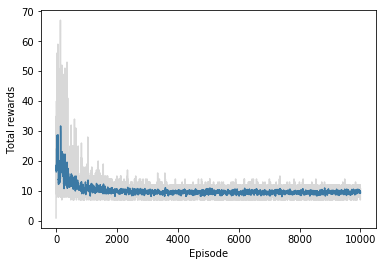

In [20]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

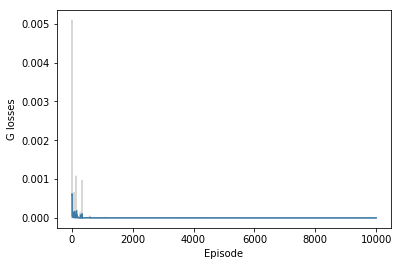

In [21]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

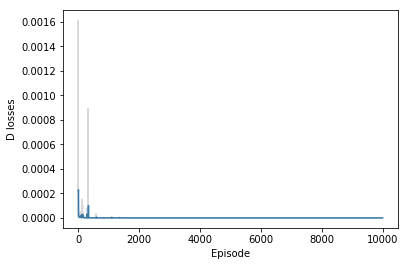

In [22]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [43]:
test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# # # Create the env after closing it.
# # env = gym.make('CartPole-v0')
# # env = gym.make('Acrobot-v1')
# env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            
            # Rendering the env graphics
            env.render()
            
            # Get action from the model
            feed_dict = {model.prev_actions: np.array([prev_action]), 
                         model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, _, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, reward, done, _ = env.step(prev_action)
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


In [45]:
# Closing the env
# WARNING: If you close, you can NOT restart again!!!!!!
env.close()

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.